#  Gravitational Wave Data Analysis tutorial #1


#### Tutorial 1.1: Discovering open data from GW observatories

This notebook describes how to discover what data are available from the [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/SylvainMarsat/gwda_tutorial/blob/main/tutorial_1.ipynb)

Author date

## Install

When running in Google Colab, uncomment and run the cell to install required packages:

In [ ]:
#! pip install numpy scipy h5py matplotlib ipython jupyterlab tqdm lalsuite gwpy

When running in Google Colab, uncomment and run the cell to download the required data:

In [ ]:
#! mkdir data
#! wget https://github.com/SylvainMarsat/gwda_tutorial/data/L-L1_LOSC_4_V2-1126259446-32.hdf5 data/

## Imports

In [4]:
import os, sys
import h5py, json
import copy
import numpy as np
import scipy
import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab

import lal
import lalsimulation as lalsim

from tqdm import tqdm as tqdm

In [2]:
plt.rcParams.update({'figure.dpi': 100})

In [3]:
losc_dir = '/Users/marsat/Projects/tutorials/gwda/LOSC_Event_tutorial/'

In [4]:
sys.path.append(losc_dir)

import readligo as rl

In [5]:
%matplotlib inline

## Definitions

In [6]:
# Read the event properties from a local json file
fnjson = losc_dir + 'BBH_events_v3.json'
events = json.load(open(fnjson, 'r'))

eventname = 'GW150914'
# eventname = 'GW151226'
events[eventname]

{'name': 'GW150914',
 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_template': 'GW150914_4_template.hdf5',
 'fs': 4096,
 'tevent': 1126259462.44,
 'utcevent': '2015-09-14T09:50:45.44',
 'm1': 41.743,
 'm2': 29.237,
 'a1': 0.355,
 'a2': -0.769,
 'approx': 'lalsim.SEOBNRv2',
 'fband': [43.0, 300.0],
 'f_min': 10.0}

In [7]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

In [8]:
def psd_smooth(freqs):
    return (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2

## Strain data

In [9]:
# read in data from H1 and L1, if available:
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(losc_dir + fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(losc_dir + fn_L1, 'L1')

# Remove a constant shift of -1e-18 in the L1 strain, not sure why it's here
strain_L1 += 1e-18

In [10]:
# both H1 and L1 will have the same time vector, so:
# set t=0 at the middle of the interval
time = time_H1 - time_H1[len(time_H1)//2]
tevent = tevent - time_H1[len(time_H1)//2]
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

dt, 1./dt, time[-1] - time[0], len(time)

(0.000244140625, 4096.0, 31.999755859375, 131072)

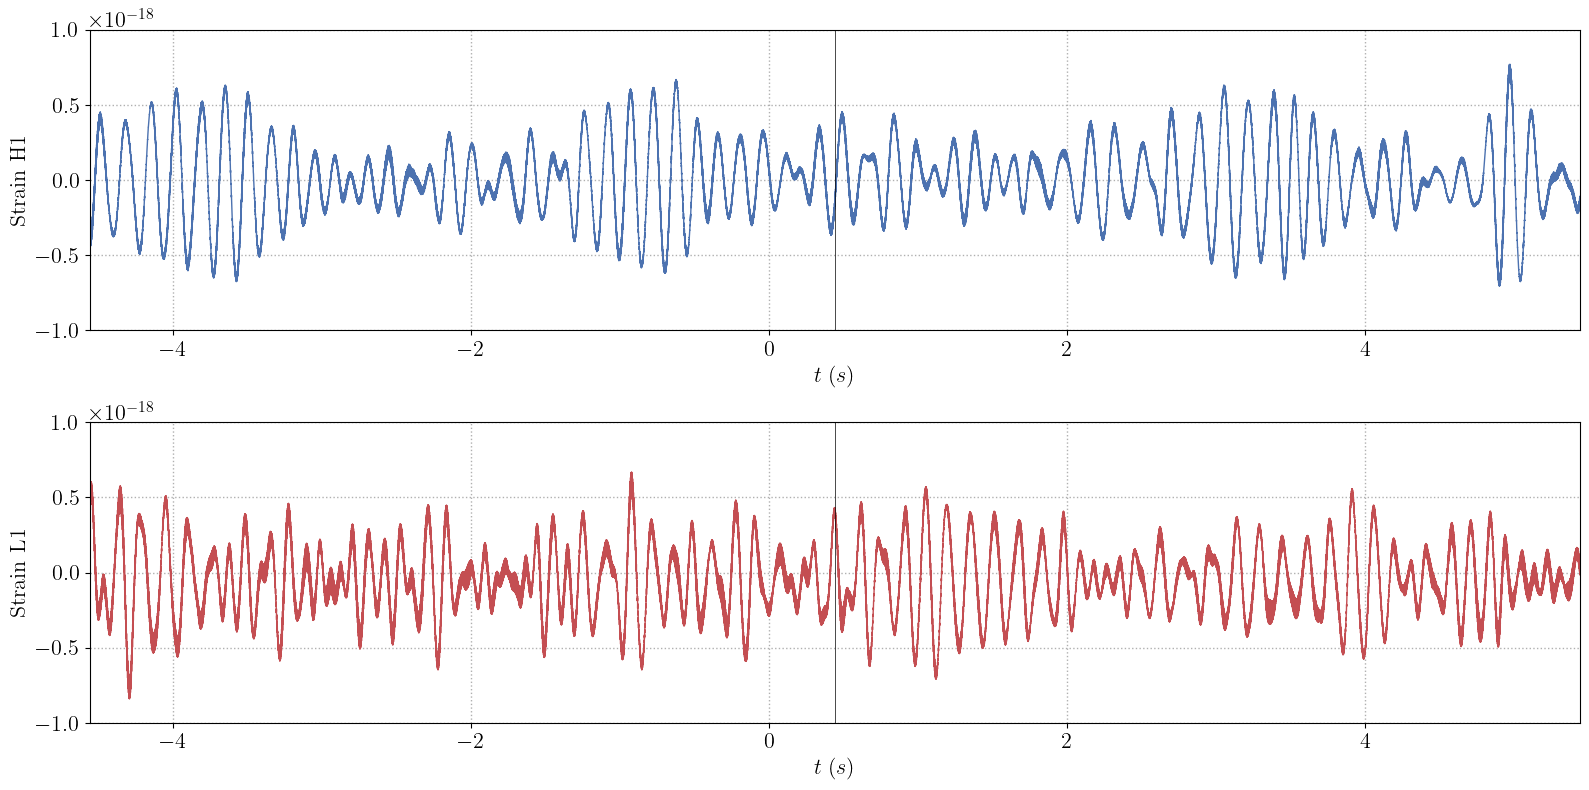

<Figure size 800x400 with 0 Axes>

In [269]:
deltat = 5
mask = (tevent - deltat <= time) & (time <= tevent + deltat)
rangey = [-1e-18, 1e-18]

fig, axs = plt.subplots(2,1, figsize=[16,8])
plotutils.lplot(axs[0], [time[mask], strain_H1[mask]], rangey=rangey)
plotutils.lplot(axs[1], [time[mask], strain_L1[mask]], colors=[plotutils.plotpalette[1]], rangey=rangey)
axs[0].set_ylabel(r'Strain H1')
axs[1].set_ylabel(r'Strain L1')
for i in range(2):
    axs[i].set_xlabel(r'$t \; (s)$')
    axs[i].axvline(tevent, c='k', lw=0.5)

fig.tight_layout()

fig.savefig('./plots/strain_raw_GW150914.pdf')

## Evaluate PSD

In [11]:
NFFT = 4*fs

Pxx_H1, freqs = mlab.psd(strain_H1, Fs=fs, NFFT=NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs=fs, NFFT=NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

In [12]:
Pxx_H1.shape

(8193,)

In [13]:
freqs

array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 2.04750e+03,
       2.04775e+03, 2.04800e+03])

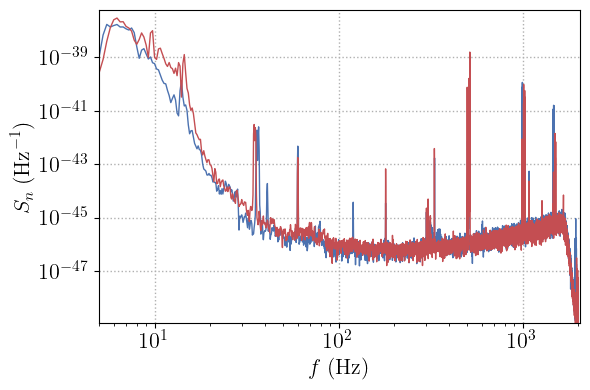

<Figure size 800x400 with 0 Axes>

In [273]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [freqs, Pxx_H1], [freqs, Pxx_L1], rangex=[5., 2048.])
ax.set_xlabel(r'$f \; (\mathrm{Hz})$')
ax.set_ylabel(r'$S_n \; (\mathrm{Hz}^{-1})$')

fig.tight_layout()

fig.savefig('./plots/psd_GW150914.pdf')

## Template from GWOSC

In [14]:
# read in the template (plus and cross) and parameters for the theoretical waveform
f_template = h5py.File(losc_dir + fn_template, "r")

# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

In [15]:
template_p.shape

(131072,)

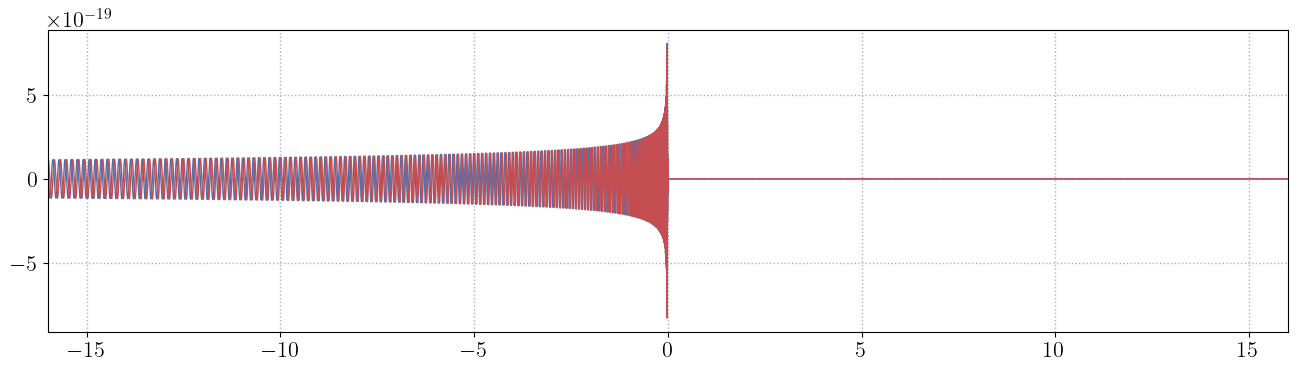

<Figure size 800x400 with 0 Axes>

In [276]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
plotutils.lplot(ax, [time, template_p], [time, template_c])

In [16]:
mask_0 = (template_p == 0.) & (template_c == 0.)
time[mask_0][0]

0.024169921875

In [17]:
template_t = time[~mask_0]
template_h = (template_p - 1j*template_c)[~mask_0]
template_amp = np.abs(template_h)
template_phase = np.unwrap(np.angle(template_h))

ipeak = np.argmax(template_amp)
tpeak = template_t[ipeak]

# Setting peak at t=0 for the template time vector
template_t -= tpeak

spline_phase = pytools.spline(template_t, template_phase)

tpeak, template_t[-1]

(-0.015869140625, 0.039794921875)

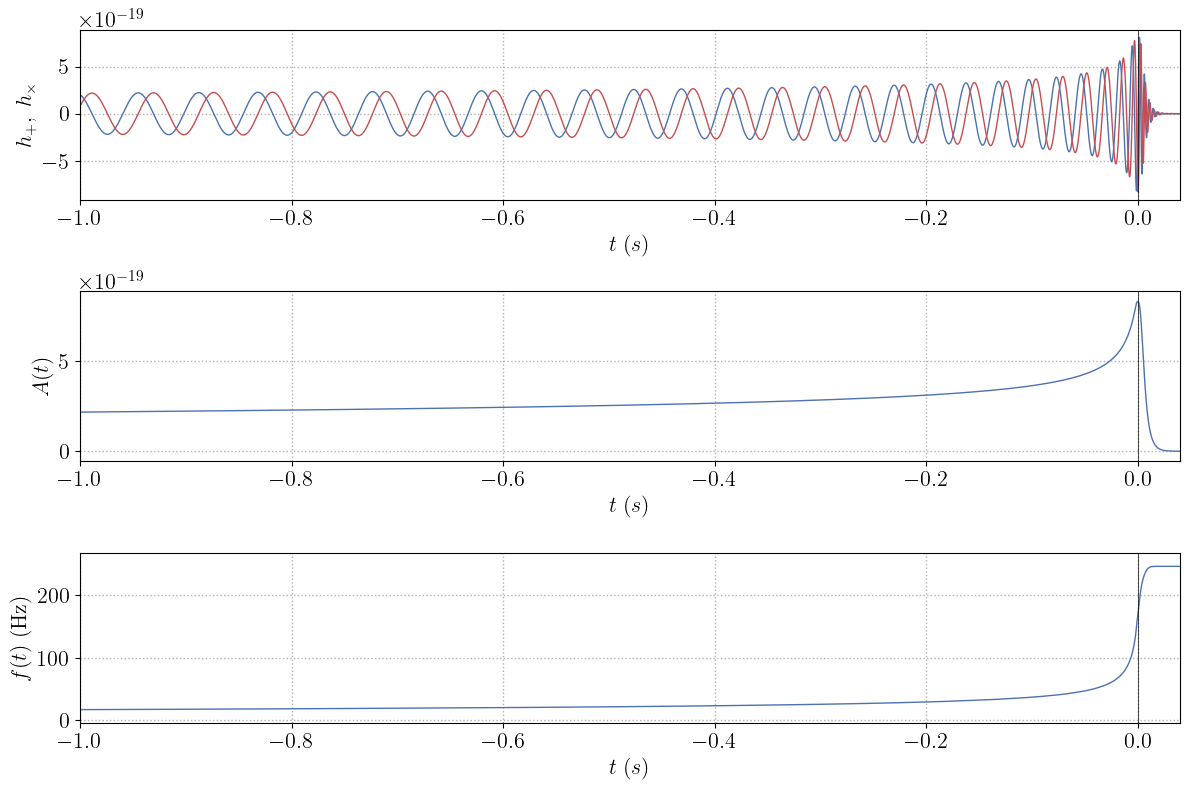

<Figure size 800x400 with 0 Axes>

In [279]:
rangex = [-1., template_t[-1]]

fig, axs = plt.subplots(3,1, figsize=[12,8])
plotutils.lplot(axs[0], [template_t, template_p[~mask_0]], [template_t, template_c[~mask_0]], rangex=rangex)
plotutils.lplot(axs[1], [template_t, template_amp], rangex=rangex)
plotutils.lplot(axs[2], [template_t, -1./(2*np.pi) * spline_phase(template_t, 1)], rangex=rangex)

for i in range(3):
    axs[i].set_xlabel(r'$t \; (s)$')
    axs[i].axvline(0., c='k', lw=0.5)
axs[0].set_ylabel(r'$h_+, \; h_\times$')
axs[1].set_ylabel(r'$A(t)$')
axs[2].set_ylabel(r'$f(t) \; (\mathrm{Hz})$')
    
fig.tight_layout()

fig.savefig('./plots/template_GW150914.pdf')

## Data visualization: tapering, band-passing, whitening, spectrogram

In [18]:
# Data selected to be +-2s around the event
# _d for 'data' that we are going to actually use

# n = 2**np.round(np.log2(4. / dt))
n = len(time)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
time_d = time[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(time_d), [time_d[0], time_d[-1]]

(131072, 32.0, 131072, [-16.0, 15.999755859375])

In [19]:
# Tapering data at both ends
# w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 0.5, 0.5)
w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 2., 2.)
strain_H1_tap = w * strain_H1_d
strain_L1_tap = w * strain_L1_d

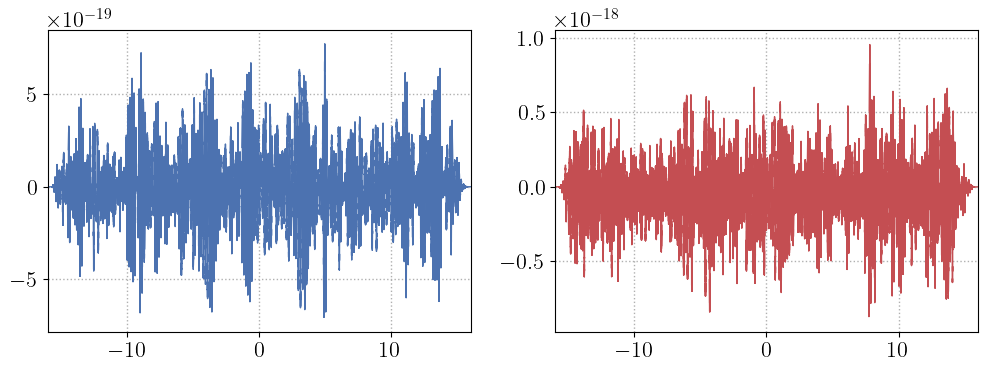

<Figure size 800x400 with 0 Axes>

In [282]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_tap])
plotutils.lplot(axs[1], [time_d, strain_L1_tap], colors=[plotutils.plotpalette[1]])

In [20]:
# Data FD
strain_H1_fd = pytools.fft_positivef(np.array([time_d, strain_H1_tap]).T)
strain_L1_fd = pytools.fft_positivef(np.array([time_d, strain_L1_tap]).T)

df = strain_H1_fd[1,0] - strain_H1_fd[0,0]
df

0.03125

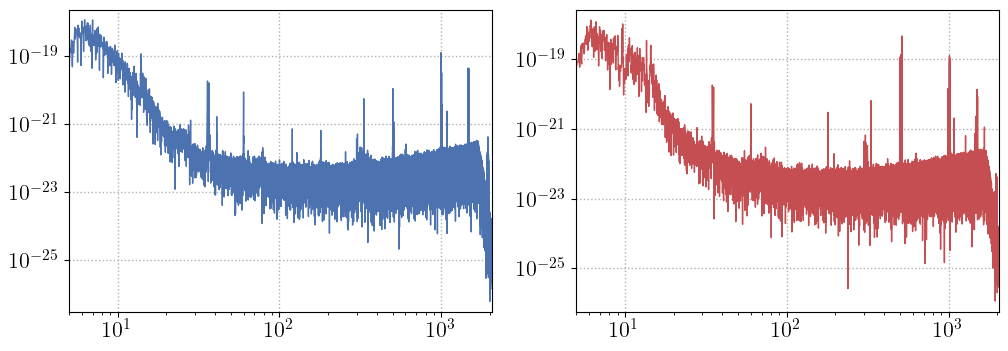

<Figure size 800x400 with 0 Axes>

In [284]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], np.abs(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

In [21]:
# Data band-passed first, before whitening

freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_bp_vals = w_fft * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
strain_L1_fd_bp_vals = w_fft * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_bp = np.array([freq_fft, np.real(strain_H1_fd_bp_vals), np.imag(strain_H1_fd_bp_vals)]).T
strain_L1_fd_bp = np.array([freq_fft, np.real(strain_L1_fd_bp_vals), np.imag(strain_L1_fd_bp_vals)]).T

strain_H1_td_bp = pytools.ifft_real(strain_H1_fd_bp)
strain_L1_td_bp = pytools.ifft_real(strain_L1_fd_bp)

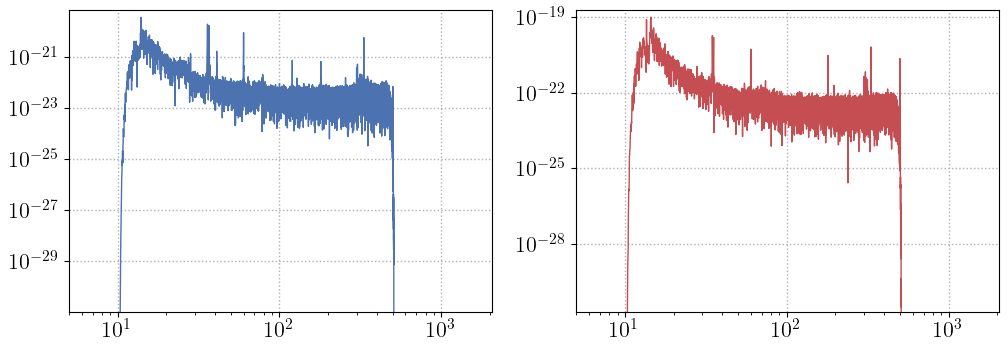

<Figure size 800x400 with 0 Axes>

In [286]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_bp[:,1] + 1j*strain_H1_fd_bp[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], np.abs(strain_L1_fd_bp[:,1] + 1j*strain_L1_fd_bp[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

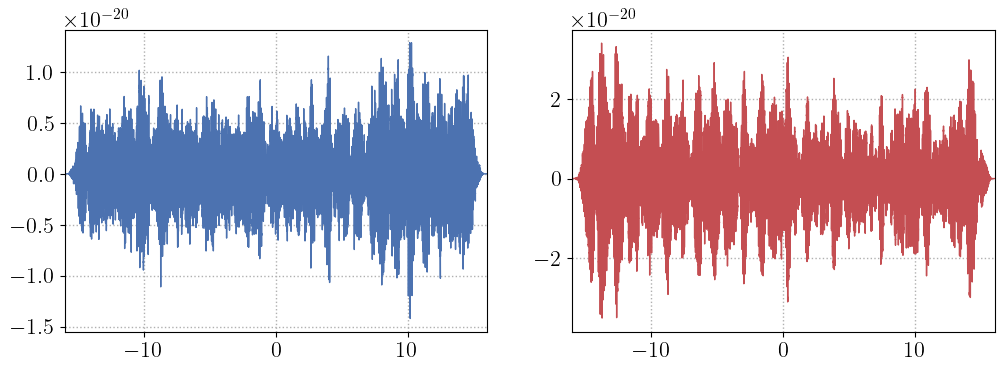

<Figure size 800x400 with 0 Axes>

In [287]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_bp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_L1_td_bp[:,1]], colors=[plotutils.plotpalette[1]])

In [22]:
# Data whitened after band-passing
freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_wbp_vals = 1./np.sqrt(psd_H1(freq_fft) / (2*df)) * (strain_H1_fd_bp[:,1] + 1j*strain_H1_fd_bp[:,2])
strain_L1_fd_wbp_vals = 1./np.sqrt(psd_L1(freq_fft) / (2*df)) * (strain_L1_fd_bp[:,1] + 1j*strain_L1_fd_bp[:,2])
# strain_H1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
# strain_L1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_wbp = np.array([freq_fft, np.real(strain_H1_fd_wbp_vals), np.imag(strain_H1_fd_wbp_vals)]).T
strain_L1_fd_wbp = np.array([freq_fft, np.real(strain_L1_fd_wbp_vals), np.imag(strain_L1_fd_wbp_vals)]).T

strain_H1_td_wbp = pytools.ifft_real(strain_H1_fd_wbp)
strain_L1_td_wbp = pytools.ifft_real(strain_L1_fd_wbp)

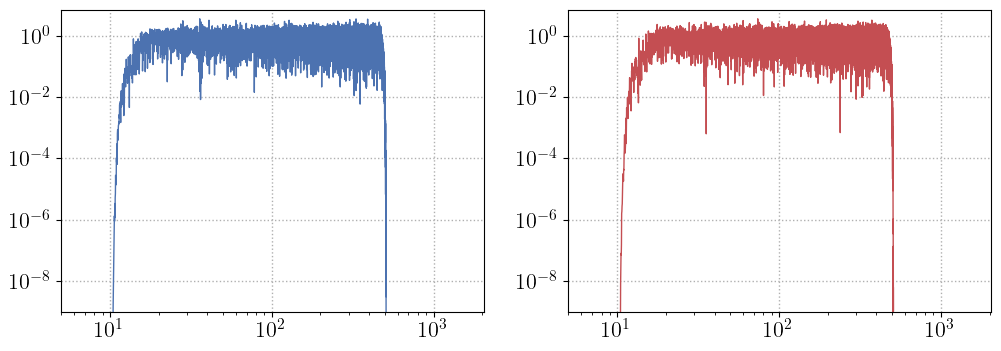

<Figure size 800x400 with 0 Axes>

In [376]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_wbp_vals)], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], np.abs(strain_L1_fd_wbp_vals)], colors=[plotutils.plotpalette[1]], rangex=rangex)

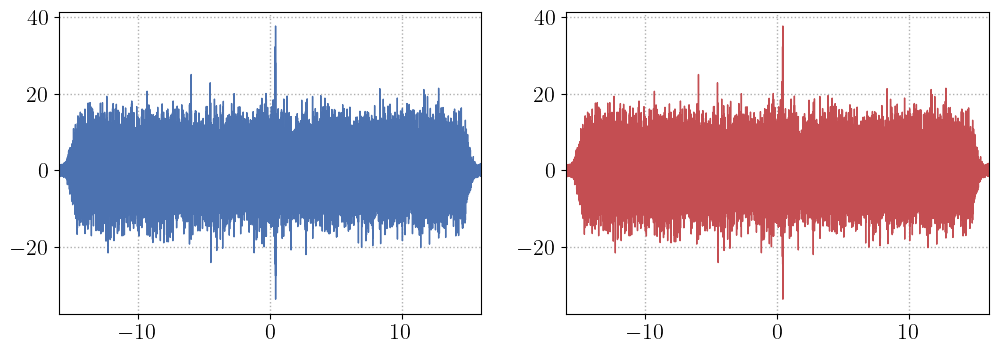

<Figure size 800x400 with 0 Axes>

In [289]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]])

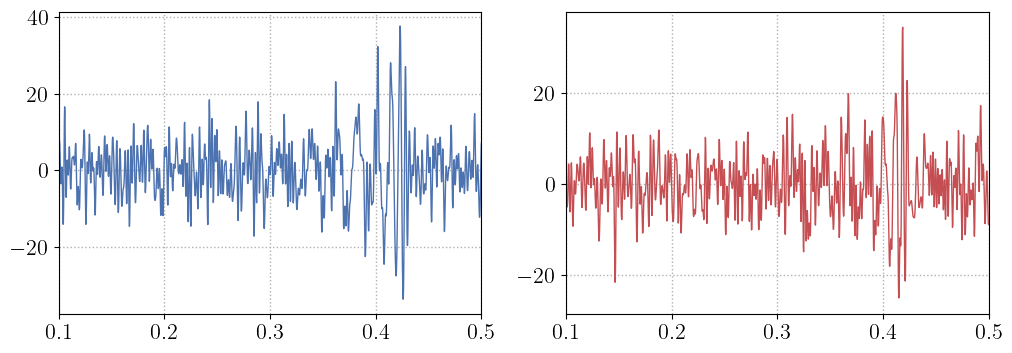

<Figure size 800x400 with 0 Axes>

In [293]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# rangex = [-0.3, 0.05]
rangex = [0.1, 0.5]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
plotutils.lplot(axs[1], [time_d, strain_L1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]], rangex=rangex)

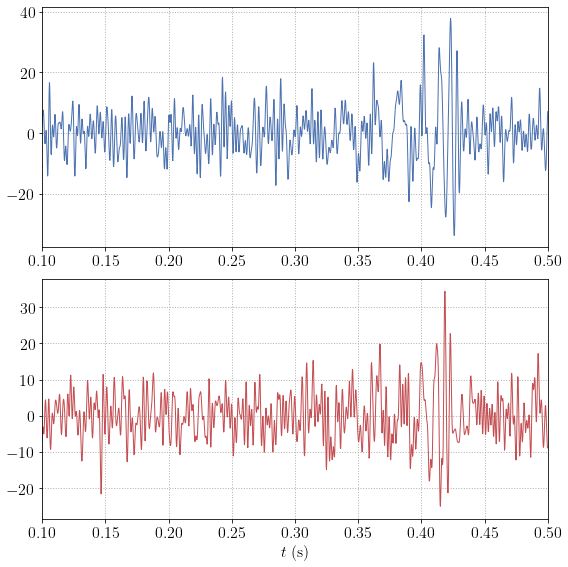

<Figure size 576x288 with 0 Axes>

In [40]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# rangex = [-0.3, 0.05]
rangex = [0.1, 0.5]

fig, axs = plt.subplots(2,1, figsize=[8,8])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
plotutils.lplot(axs[1], [time_d, strain_L1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]], rangex=rangex)

axs[1].set_xlabel(r'$t \; (\mathrm{s})$')

fig.tight_layout()

fig.savefig('./plots/data_td_wbp_zoom.pdf', dpi=300)

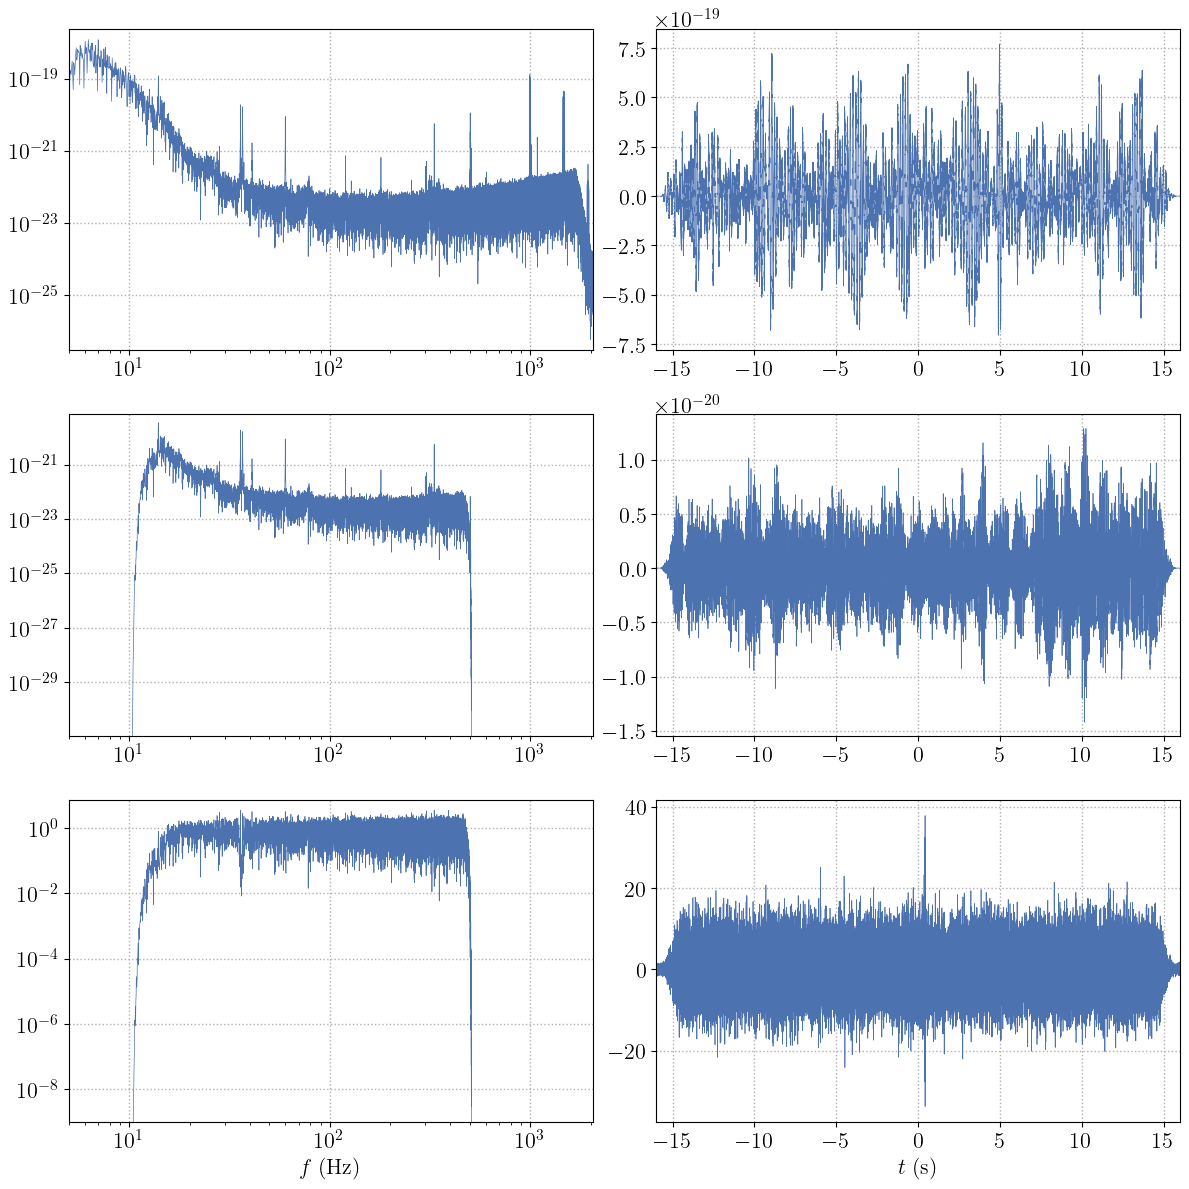

<Figure size 800x400 with 0 Axes>

In [391]:
rangex = [5., 2048.]

fig, axs = plt.subplots(3,2, figsize=[12,12])
plotutils.lplot(axs[0,1], [time_d, strain_H1_tap], linewidths=[0.5])
plotutils.lloglogplot(axs[0,0], [strain_H1_fd[:,0], np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex, linewidths=[0.5])
plotutils.lplot(axs[1,1], [time_d, strain_H1_td_bp[:,1]], linewidths=[0.5])
plotutils.lloglogplot(axs[1,0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_bp[:,1] + 1j*strain_H1_fd_bp[:,2])], rangex=rangex, linewidths=[0.5])
plotutils.lplot(axs[2,1], [time_d, strain_H1_td_wbp[:,1]], linewidths=[0.5])
plotutils.lloglogplot(axs[2,0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_wbp_vals)], rangex=rangex, linewidths=[0.5])

axs[2,1].set_xlabel(r'$t \; (\mathrm{s})$')
axs[2,0].set_xlabel(r'$f \; (\mathrm{Hz})$')

fig.tight_layout()

fig.savefig('./plots/data_tdfd_bp_w.pdf', dpi=300)

### Devel

In [173]:
# Data whitened in TD
# NOTE: use smooth PSD here, otherwise problems when not band-passing, see plot below
freq_fft = strain_H1_fd[:,0]
# strain_H1_fd_w_vals = 1./np.sqrt(psd_H1(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
# strain_L1_fd_w_vals = 1./np.sqrt(psd_L1(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_w_vals = 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
strain_L1_fd_w_vals = 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_w = np.array([freq_fft, np.real(strain_H1_fd_w_vals), np.imag(strain_H1_fd_w_vals)]).T
strain_L1_fd_w = np.array([freq_fft, np.real(strain_L1_fd_w_vals), np.imag(strain_L1_fd_w_vals)]).T

strain_H1_td_w = pytools.ifft_real(strain_H1_fd_w)
strain_L1_td_w = pytools.ifft_real(strain_L1_fd_w)

In [171]:
dt, strain_H1_td_w[1,0] - strain_H1_td_w[0,0]

(0.000244140625, 0.000244140625)

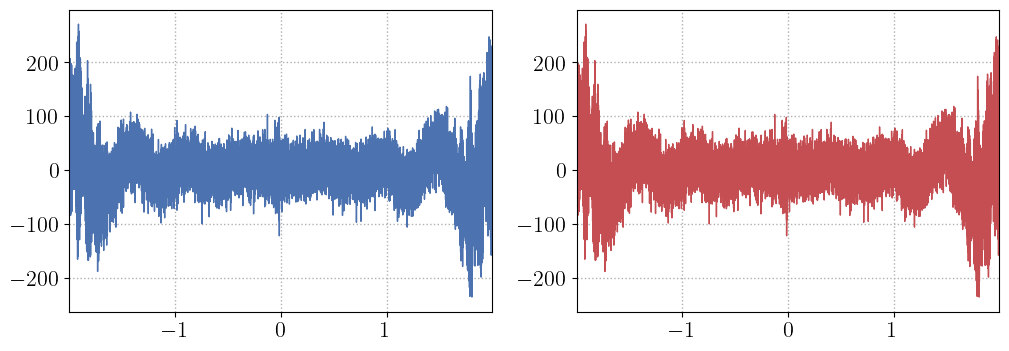

<Figure size 800x400 with 0 Axes>

In [172]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# fig, axs = plt.subplots(1,2, figsize=[12,4])
# plotutils.lplot(axs[0], [time_d, strain_H1_td_w[:,1]])
# plotutils.lplot(axs[1], [time_d, strain_H1_td_w[:,1]], colors=[plotutils.plotpalette[1]])

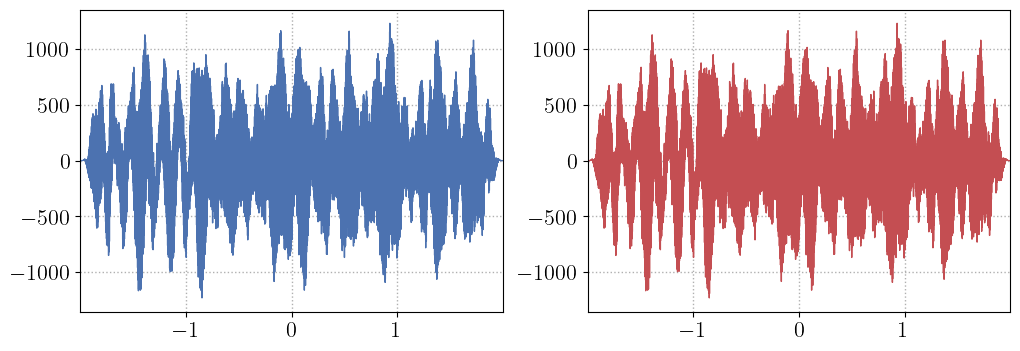

<Figure size 800x400 with 0 Axes>

In [174]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# NOTE: with smooth noise, lines are not whitened and dominate
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_w[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_w[:,1]], colors=[plotutils.plotpalette[1]])

In [187]:
# Data whitened and band-passed in TD
# NOTE: use smooth PSD here, otherwise problems when not band-passing, see plot below
freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_H1(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
strain_L1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_L1(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
# strain_H1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
# strain_L1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_wbp = np.array([freq_fft, np.real(strain_H1_fd_wbp_vals), np.imag(strain_H1_fd_wbp_vals)]).T
strain_L1_fd_wbp = np.array([freq_fft, np.real(strain_L1_fd_wbp_vals), np.imag(strain_L1_fd_wbp_vals)]).T

strain_H1_td_wbp = pytools.ifft_real(strain_H1_fd_wbp)
strain_L1_td_wbp = pytools.ifft_real(strain_L1_fd_wbp)

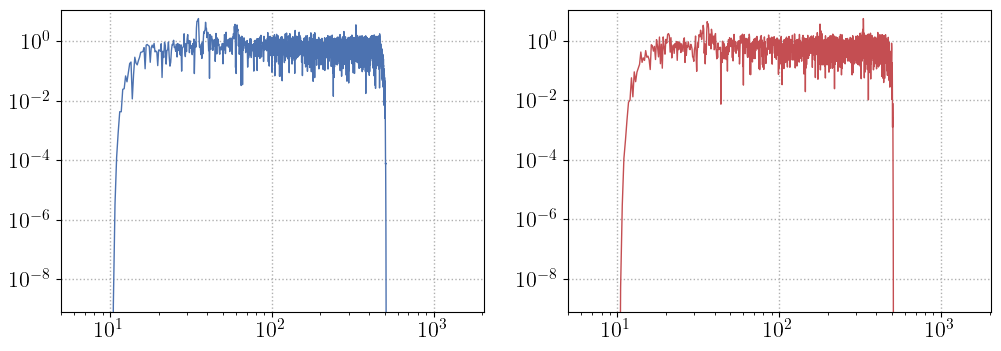

<Figure size 800x400 with 0 Axes>

In [185]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], w_fft * 2*df / np.sqrt(psd_H1(freq_fft)) * np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], w_fft * 2*df / np.sqrt(psd_L1(freq_fft)) * np.abs(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

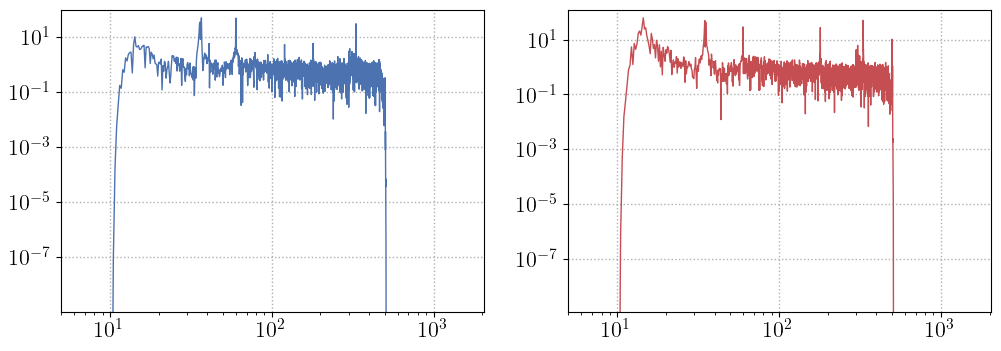

<Figure size 800x400 with 0 Axes>

In [182]:
# NOTE: problem when using the smooth PSD here, lines dominate
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], w_fft * 2*df / np.sqrt(psd_smooth(freq_fft)) * np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], w_fft * 2*df / np.sqrt(psd_smooth(freq_fft)) * np.abs(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

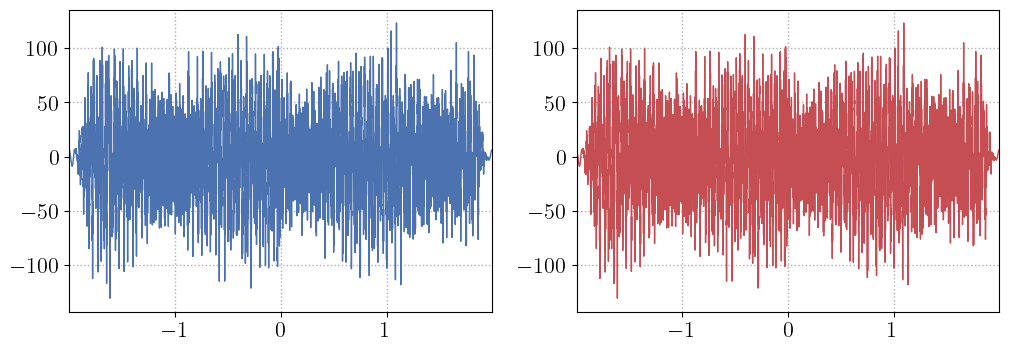

<Figure size 800x400 with 0 Axes>

In [180]:
# NOTE: problem when using the smooth PSD here, lines dominate
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]])

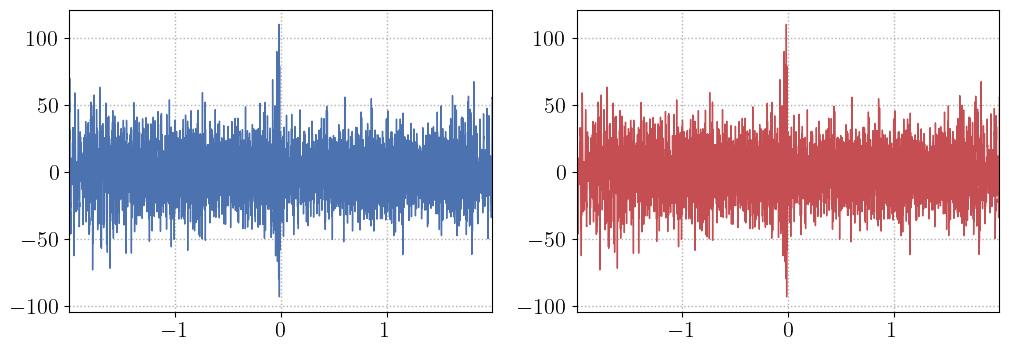

<Figure size 800x400 with 0 Axes>

In [188]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]])

## Matched filter

In [23]:
# Template FD
# Tapering data at both ends
# Shift in time so that t=0 for templae is at tpeak
# w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 0.5, 0.5)
w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 2., 2.)
template_fd = pytools.fft_positivef(np.array([time_d, w * template_p[mask_d], -w * template_c[mask_d]]).T)

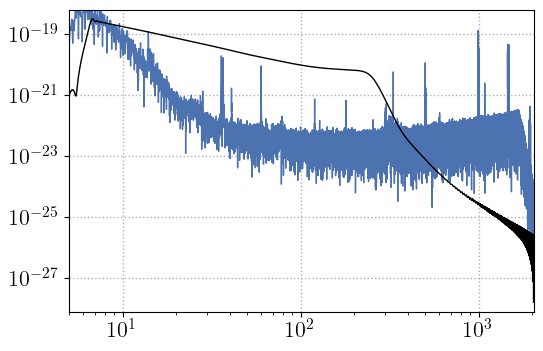

<Figure size 800x400 with 0 Axes>

In [298]:
#NOTE: amplitude of the template (which is arbitrary, we will normalize) is huge here it seems
rangex = [5., 2048.]

fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [strain_H1_fd[:,0], np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(ax, [template_fd[:,0], np.abs(template_fd[:,1] + 1j*template_fd[:,2])], colors=['k'], rangex=rangex)

In [24]:
# Frequencies bounds for inner product
mask = (10. < template_fd[:,0]) & (template_fd[:,0] < 1024.)
freq = template_fd[:,0]
w_fd = pytools.window_planck_vec(freq_fft, 5., 1024., 5., 128.)

In [25]:
# Wiener filter formed with this template
W_H1_fd = np.array([freq, w_fd * 2 / psd_H1(freq) * template_fd[:,1], w_fd * 2 / psd_H1(freq) * template_fd[:,2]]).T
W_L1_fd = np.array([freq, w_fd * 2 / psd_L1(freq) * template_fd[:,1], w_fd * 2 / psd_L1(freq) * template_fd[:,2]]).T

In [26]:
# Normalization: N = (h|h)
integrand_hh_H1 = w_fd * np.abs(template_fd[:,1] + 1j*template_fd[:,2])**2 / psd_H1(freq)
integrand_hh_L1 = w_fd * np.abs(template_fd[:,1] + 1j*template_fd[:,2])**2 / psd_L1(freq)
hh_H1 = 4*df * np.sum((integrand_hh_H1[1:] + integrand_hh_H1[:-1]) / 2)
hh_L1 = 4*df * np.sum((integrand_hh_L1[1:] + integrand_hh_L1[:-1]) / 2)
N_H1 = np.sqrt(hh_H1)
N_L1 = np.sqrt(hh_L1)
N_H1, N_L1

(31686.09292368623, 27414.265777006367)

In [27]:
# IFFT for time shifts
# Integrand: we compute (s|h) / sqrt((h|h)) = (s|h)/N with exp(+-2pi i f Deltat) (sign to check)
# NOTE: check the sign, here conjugation to make it work

# NOTE: factor 2 because we use ifft_positivef for a clearer impact of Deltaphi, but doing so we set negative frequencies to 0

integrand_H1 = w_fd * 1./N_H1 * (W_H1_fd[:,1] + 1j*W_H1_fd[:,2]) * np.conj(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
integrand_L1 = w_fd * 1./N_L1 * (W_L1_fd[:,1] + 1j*W_L1_fd[:,2]) * np.conj(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])

# NOTE: mind the factor 2, because ifft_positivef sets negative frequencies to 0
ifft_H1_ts = 2 * pytools.ifft_positivef(np.array([template_fd[:,0], np.real(integrand_H1), -np.imag(integrand_H1)]).T)
ifft_L1_ts = 2 * pytools.ifft_positivef(np.array([template_fd[:,0], np.real(integrand_L1), -np.imag(integrand_L1)]).T)

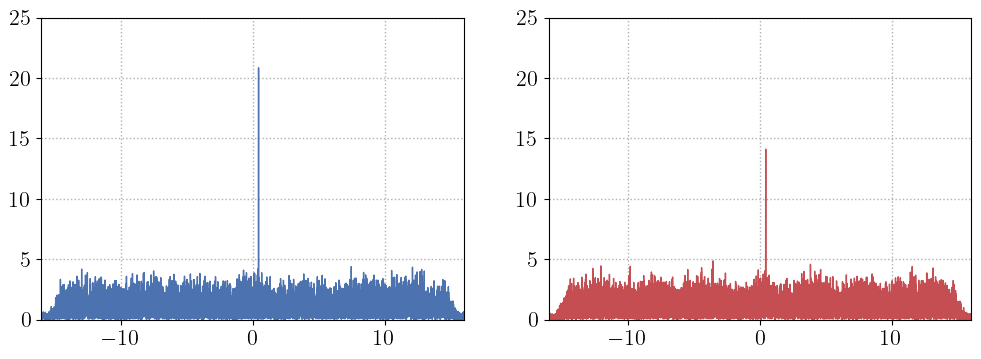

<Figure size 800x400 with 0 Axes>

In [343]:
# NOTE: this shows \rho optimized over phase shift, for different times shifts

rangex = None
rangey = [0., 25.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, np.abs(ifft_H1_ts[:,1] + 1j*ifft_H1_ts[:,2])], rangex=None, rangey=rangey)
plotutils.lplot(axs[1], [time_d, np.abs(ifft_L1_ts[:,1] + 1j*ifft_L1_ts[:,2])], rangex=None, rangey=rangey, colors=[plotutils.plotpalette[1]])

In [28]:
# PROBLEM: abs value from optimization over phase -- what is the expected distribution ?

mask_test = (-12 < time_d) & (time_d < 0.)
np.mean(np.abs(ifft_H1_ts[mask_test,1] + 1j*ifft_H1_ts[mask_test,2])**2), np.mean(np.abs(ifft_L1_ts[mask_test,1] + 1j*ifft_L1_ts[mask_test,2])**2)

(2.1444979212605615, 2.119932787647866)

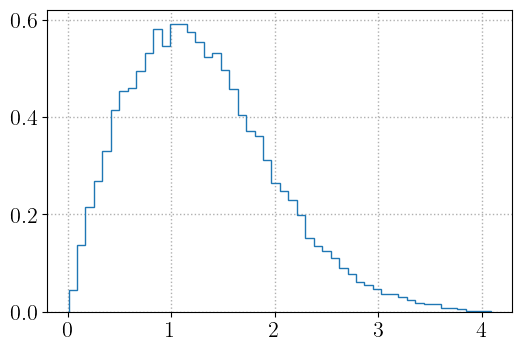

In [393]:
# NOTE: distribution of \rho optimized 

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(np.abs(ifft_H1_ts[mask_test,1] + 1j*ifft_H1_ts[mask_test,2]), histtype='step', density=True);

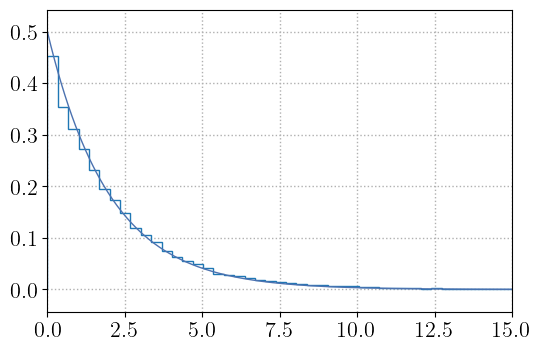

<Figure size 800x400 with 0 Axes>

In [395]:
# NOTE: distribution of \rho^2=R optimized, chi2 with 2 degrees of freedom

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(np.abs(ifft_H1_ts[mask_test,1] + 1j*ifft_H1_ts[mask_test,2])**2, histtype='step', density=True);

Rvals = np.linspace(0., 15., 400)
plotutils.lplot(ax, [Rvals, 1./2*np.exp(-Rvals/2)])

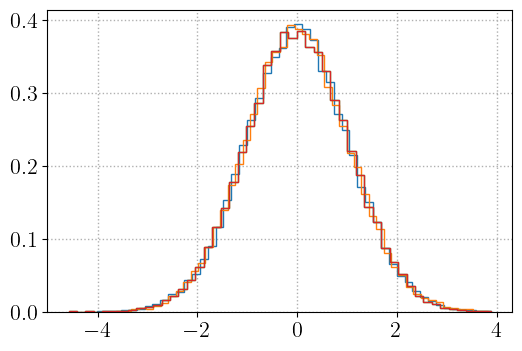

In [351]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(ifft_H1_ts[mask_test,1], histtype='step', density=True);
ax.hist(ifft_H1_ts[mask_test,2], histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,2], histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,2], histtype='step', density=True);

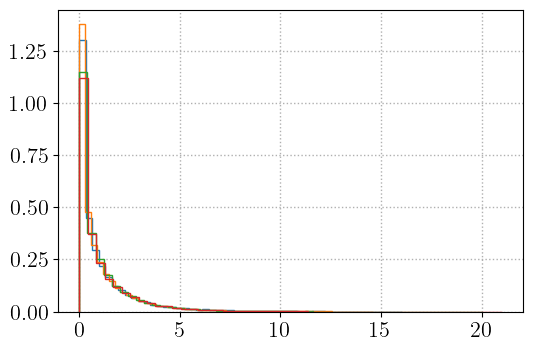

In [352]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(ifft_H1_ts[mask_test,1]**2, histtype='step', density=True);
ax.hist(ifft_H1_ts[mask_test,2]**2, histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,1]**2, histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,2]**2, histtype='step', density=True);

In [349]:
np.std(ifft_H1_ts[mask_test,1]), np.std(ifft_H1_ts[mask_test,2])

(1.0354781042631842, 1.0355109925513837)

## Plot for distribution of SNR^2

In [364]:
SNR = np.sqrt(16)
Rbar = SNR**2

Rvals = np.linspace(0., 30., 400)
p_n = 1./2 * np.exp(-1./2*Rvals)
p_s = 1./2 * np.exp(-1./2*(Rvals+Rbar)) * scipy.special.iv(0, np.sqrt(Rvals * Rbar))

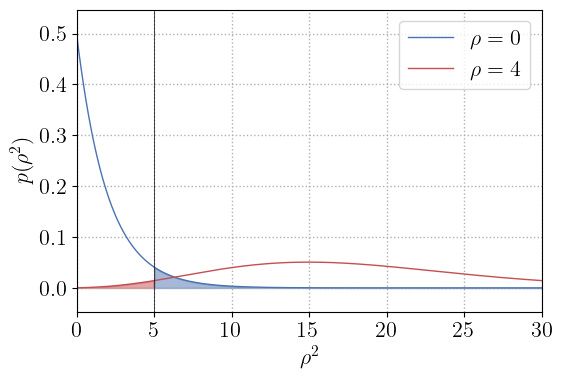

<Figure size 800x400 with 0 Axes>

In [375]:
Rthres = 5

fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lplot(ax, [Rvals, p_n], [Rvals, p_s], labels=[r'$\rho=0$', r'$\rho=4$'])
ax.fill_between(Rvals[Rvals > Rthres], 0., p_n[Rvals > Rthres], color=plotutils.plotpalette[0], alpha=0.5)
ax.fill_between(Rvals[Rvals < Rthres], 0., p_s[Rvals < Rthres], color=plotutils.plotpalette[1], alpha=0.5)
ax.axvline(Rthres, c='k', lw=0.5)
ax.set_xlabel(r'$\rho^2$')
ax.set_ylabel(r'$p(\rho^2)$')

ax.legend(loc='upper right')

fig.savefig('./plots/p_of_rho2.pdf')

## Plot for white noise

In [116]:
deltax = 1./4096
x = np.arange(-5., 5., deltax)

white_noise = np.random.normal(0, 1., size=len(x))

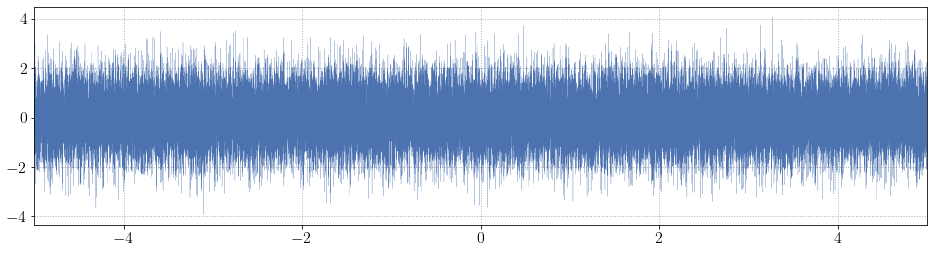

<Figure size 576x288 with 0 Axes>

In [119]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
plotutils.lplot(ax, [x, white_noise], linewidths=[0.2])

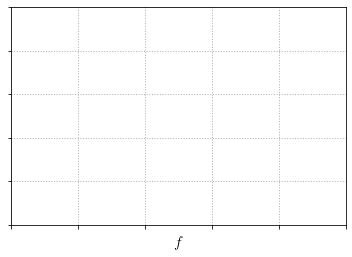

In [122]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_xlabel(r'$f$')
ax.set_xticklabels('');
ax.set_yticklabels('');

# Video

In [ ]:
# def generate_video(img):
#     for i in xrange(len(img)):
#         plt.imshow(img[i], cmap=cm.Greys_r)
#         plt.savefig(folder + "/file%02d.png" % i)
# 
#     os.chdir("your_folder")
#     subprocess.call([
#         'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
#         'video_name.mp4'
#     ])
#     for file_name in glob.glob("*.png"):
#         os.remove(file_name)

# Needed also https://stackoverflow.com/questions/20847674/ffmpeg-libx264-height-not-divisible-by-2

# Final command:

# ffmpeg -framerate 20 -i signal_rho_frame_%04d.png -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" video_signal_rho.mp4

In [53]:
alpha_td = np.arctan2(ifft_H1_ts[:,2], ifft_H1_ts[:,1])
A_td = np.abs(ifft_H1_ts[:,1] + 1j*ifft_H1_ts[:,2]) / N_H1

rho = np.abs(ifft_H1_ts[:,1] + 1j*ifft_H1_ts[:,2])
iopt = np.argmax(rho)
A_opt = A_td[iopt]
alpha_opt = alpha_td[iopt]
Deltat_opt = time_d[iopt]

In [55]:
A_opt, alpha_opt, Deltat_opt

(0.0006578358337716319, -2.240744996338205, 0.439453125)

In [73]:
freq_fft = strain_H1_fd[:,0]
mask_ext = (5. < freq_fft) & (freq_fft < 1024.)
freq_ext = freq_fft[mask_ext]

def htemplate_wbp_td(A, Deltat, alpha):
    w_ifft = pytools.window_planck_vec(freq_ext, 5., 1024., 5., 128.)
    h_fd = np.zeros_like(freq_fft, dtype=complex)
    h_fd[mask_ext] = w_ifft * A * np.exp(1j*alpha) * np.exp(2*1j*np.pi*freq_fft[mask_ext]*Deltat) * (template_fd[mask_ext,1] + 1j*template_fd[mask_ext,2])
    h_wbp_fd =  1./np.sqrt(psd_H1(freq_fft) / (2*df)) * h_fd 
    return pytools.ifft_real(np.array([freq_fft, np.real(h_wbp_fd), np.imag(h_wbp_fd)]).T)

In [74]:
ht_wbp_opt = htemplate_wbp_td(A_opt, Deltat_opt, alpha_opt)

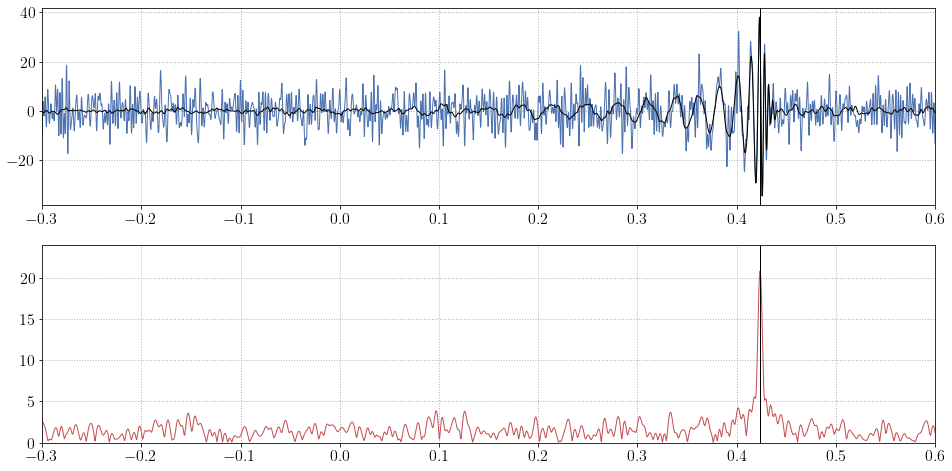

<Figure size 576x288 with 0 Axes>

In [89]:
# Take into account tpeak in Deltat_tot: template was not peaked at t=0 originally

rangex = [-0.3, 0.6]

fig, axs = plt.subplots(2,1, figsize=[16,8])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
plotutils.lplot(axs[0], [time_d, ht_wbp_opt[:,1]], rangex=rangex, colors=['k'])

plotutils.lplot(axs[1], [time_d + tpeak, rho], rangex=rangex, rangey=[0., 24.], colors=[plotutils.plotpalette[1]])

for i in range(2):
    axs[i].axvline(Deltat_opt + tpeak, c='k', lw=1.)

In [80]:
mask_plt = (-0.3 < time_d) & (time_d < 0.6)
time_d[mask_plt].shape, time_d[mask_plt].shape[0]//20

((3686,), 184)

In [83]:
# 20s of video, 20 fps
time_d[mask_plt].shape[0] / 400.

9.215

In [114]:
rangex = [-0.3, 0.6]

def plt_signal_rho(itime, iframe):
    Deltat = time_d[itime]
    A = A_td[itime]
    alpha = alpha_td[itime]
    ht_wbp = htemplate_wbp_td(A, Deltat, alpha)
    
    fig, axs = plt.subplots(2,1, figsize=[16,8]);
    plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex, rangey=[-40., 40.])
    plotutils.lplot(axs[0], [time_d, ht_wbp[:,1]], rangex=rangex, rangey=[-40., 40.], colors=['k'])

    plotutils.lplot(axs[1], [time_d + tpeak, rho], rangex=rangex, rangey=[0., 24.], colors=[plotutils.plotpalette[1]])
    
    for i in range(2):
        axs[i].axvline(Deltat_opt + tpeak, c='k', lw=2.)
        axs[i].axvline(Deltat + tpeak, c='k', lw=2., ls='--')
        
    axs[1].set_xlabel(r'$t \; (\mathrm{s})$')
        
    fig.tight_layout()
    
    fig.savefig('./videos/signal_rho_frame_%04d.png' % iframe, dpi=200)
    
    plt.close(fig)

In [115]:
ds = 9
inds = np.arange(len(time_d))[mask_plt]
inds_ds = inds[::ds]

for iframe in tqdm(range(len(inds_ds))):
    itime = inds_ds[iframe]
    plt_signal_rho(itime, iframe)

100%|███████████████████████████████████████████████████████████████████████████████████| 410/410 [03:43<00:00,  1.84it/s]


<Figure size 576x288 with 0 Axes>